# About: Notebooks for Elasticsearch README

Literate Computing for Reproducible Infrastructure: Elasticsearch運用をJupyter + Ansibleでおこなう際のお手本Notebookです。

このリポジトリでは、Elasticsearch( https://www.elastic.co/jp/products/elasticsearch )の環境を構築し、運用するためのNotebook例を紹介しています。

**なお、これらのNotebookはNIIクラウドチーム内で行っている作業の考え方を示すためのもので、環境によってはそのままでは動作しないものもあります。**

----

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

Literate-computing-Elasticsearch (c) by National Institute of Informatics

Literate-computing-Elasticsearch is licensed under a
Creative Commons Attribution 4.0 International License.

You should have received a copy of the license along with this
work. If not, see <http://creativecommons.org/licenses/by/4.0/>.

## Elasticsearchとは？
Elasticsearchは、リアルタイムにデータを検索/分析するための分散型の全文検索エンジンであり、次のような特徴を持っています。

1. __リアルタイム分析__  
収集したデータをリアルタイムに検索/分析することができます。  
また、高速に検索できるため、他のBIツールのように事前に分析項目を決めなくても、すでに蓄積されたデータに対してインタラクティブな分析をすることが可能です。

2. __クラスタリングが容易__  
クラスタリングを想定した設計が行われており、他のミドルウェアを利用せずにクラスタを組むことができます。  
ノードを追加することによりスケールアウトできるため、必要な処理性能や可用性などに応じたコントロールが容易です。

3. __ドキュメント指向、スキーマフリー__  
データベースであれば、データをレコードの単位で管理しますが、
Elasticsearchではドキュメントと呼ばれる構造化されたJSONデータの形式で管理します。  
すべてのフィールドはデフォルトでインデックスされるため、簡単かつ高速に検索できます。  
また、このドキュメントはスキーマを決めずに投入することもできるため、すぐに使い始めることができます。  
なお、ログデータのような構造化されていないデータを投入する際には、Logstashなどを用いてJSON形式に加工して保持することになります。

4. __REST API__  
Elasticsearchはシンプルで使いやすいREST APIを提供しています。  
検索処理や登録処理（indexing）だけでなく、インデックスやマッピングの定義、クラスタ管理やメンテナンスなど、Elasticsearchのクラスタ・ノードに対する操作は、ほぼすべてAPIを通じて実施できます。

5. __オープンソース__  
Elasticsearchはオープンソース製品として開発されています。  
ライセンスはApache License Version 2.0です。  
ただし、一部のプラグインを利用するためにはサブスクリプション契約（兼サポート契約）を結ぶ必要があります。

参考）[Elasticsearch公式ページ]( https://www.elastic.co/jp/products )

## 前提条件
このNotebookで前提にしているOS/ミドルウェアのバージョンは次の通りです。

| OS/ミドルウェア | バージョン |
|----|----|
|Elasticserach|elasticsearch-5.0.0-1.noarch|
|Logstash|logstash-5.0.0-1.noarch|
|Ansible|2.2.0.0|
|OS|CentOS Linux release 7.2.1511|
|JDK|jdk1.8.0_112-1.8.0_112-fcs.x86_64|


# お手本Notebook

お手本NotebookはこのNotebookと同じディレクトリにあります。

Notebook名は `XX_(XX_)Notebook名` の形で表現され、Jupyter Notebookのファイル一覧の上でも整理された形で表示できるようにしてあります。

## お手本Notebookの一覧

お手本Notebookとそれぞれの利用局面の関係については、以下のフローを参考にしてください。

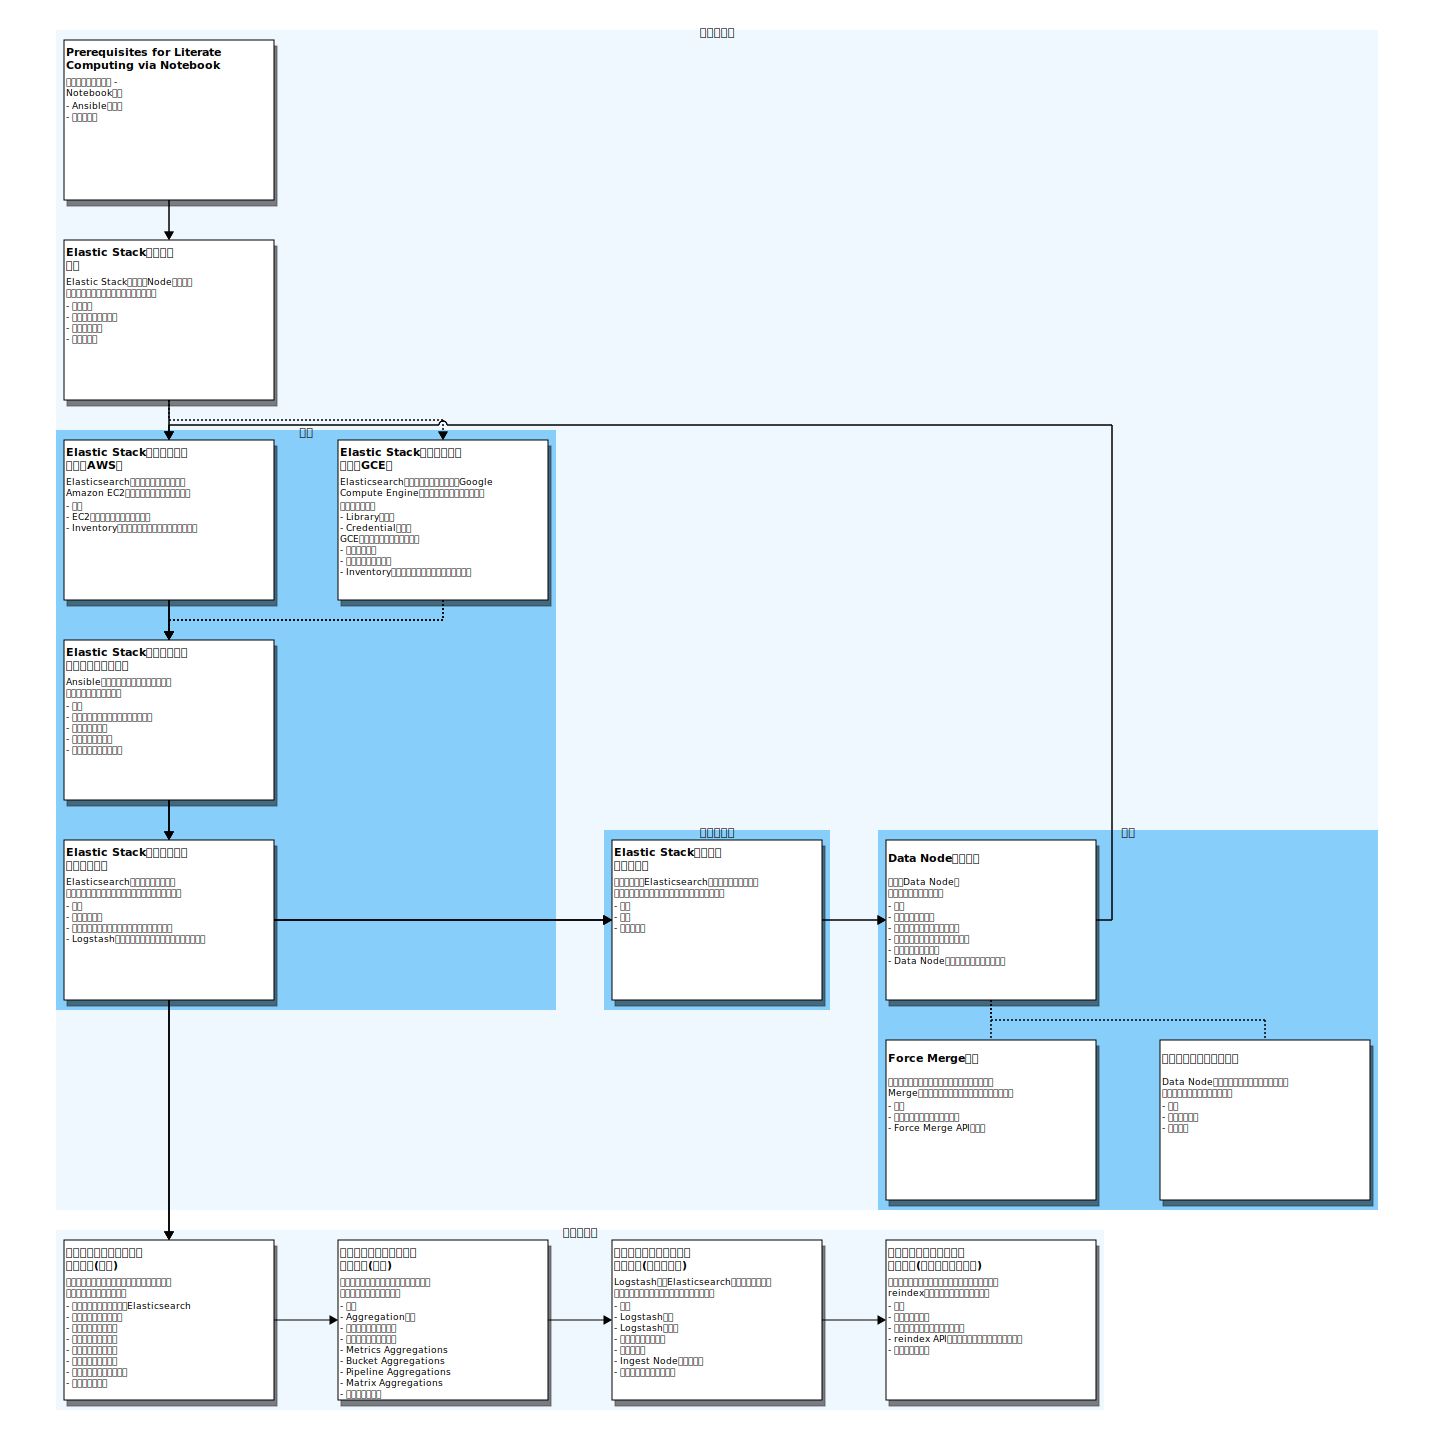

In [1]:
from IPython.display import SVG
SVG(filename='images/notebooks-filled.svg')

*構築*フェーズは、構築・運用対象とするElasticsearchのためのマシンを準備し、ソフトウェアのインストール、設定を行います。

*確認・診断*フェーズは、構築したElasticsearchの日々の運用や、問題発生時の健康診断を行います。

*改善*フェーズは、健康診断の結果、Nodeの追加により容量を増やしたり、データをクリーンアップしたりといった操作を行います。

## お手本Notebookの目次一覧

各Notebookの詳細な目次を参照するには、以下のセルを実行(`Run cell`)してください。Notebookファイルへのリンクが表示されます。

In [2]:
%run scripts/get-display-contents.py
display_notebook_contents()

/usr/local/lib/python2.7/dist-packages/cffi/model.py:525: UserWarning: 'point_conversion_form_t' has no values explicitly defined; guessing that it is equivalent to 'unsigned int'
  % self._get_c_name())


## お手本Notebookと証跡Notebook

お手本Notebookを使う場合は、お手本をコピーし、そのコピーを開きます。このように、**お手本と作業証跡は明確に分けながら作業をおこないます。**

また、お手本をコピーする際は、 `YYYYMMDD_NN_` といった実施日を示すプレフィックスを付加することで、後で整理しやすくしています。

## 実際にお手本Notebookを使ってみる

以下のJavaScriptを実行することで、簡単にお手本から作業用Notebookを作成することもできます。

以下のセルを実行すると、Notebook名のドロップダウンリストと[作業開始]ボタンが現れます。
[作業開始]ボタンを押すと、お手本Notebookのコピーを作成した後、自動的にブラウザでコピーが開きます。
Notebookの説明を確認しながら実行、適宜修正しながら実行していってください。

In [3]:
from datetime import datetime
import shutil

def copy_ref_notebook(src):
    prefix = datetime.now().strftime('%Y%m%d') + '_'
    index = len(filter(lambda name: name.startswith(prefix), os.listdir('.'))) + 1
    new_notebook = '{0}{1:0>2}_{2}'.format(prefix, index, src)
    shutil.copyfile(src, new_notebook)
    print(new_notebook)

ref_notebooks = filter(lambda m: m, map(lambda n: re.match(r'([0-9][0-9a-z]+_.*)\.ipynb', n), os.listdir('.')))
ref_notebooks = sorted(ref_notebooks, key=lambda m: m.group(1))

frags = map(lambda m: '<option value="{name}">{title}</option>'.format(name=m.group(0), title=m.group(1)),
            ref_notebooks)
HTML('''
<script type="text/Javascript">
    function copy_otehon() {
        var sel = document.getElementById('selector');
        IPython.notebook.kernel.execute('copy_ref_notebook("' + sel.options[sel.selectedIndex].value + '")',
                       {'iopub': {'output': function(msg) {
                           window.open(msg.content.text, '_blank')
                       }}});
    }
</script>
<select id="selector">''' + ''.join(frags) + '</select><button onclick="copy_otehon()">作業開始</button>')

## お手本のアーカイブ

以下のセルで、お手本NotebookのZIPアーカイブを作成できます

In [5]:
ref_notebooks = filter(lambda m: m, map(lambda n: re.match(r'([A-Z][0-9][0-9a-z]+_.*)\.ipynb', n), os.listdir('.')))
ref_notebooks = sorted(ref_notebooks, key=lambda m: m.group(1))
!zip ref_notebooks-{datetime.now().strftime('%Y%m%d')}.zip *.ipynb {' '.join(map(lambda n: '"' + n.group(0) + '"', ref_notebooks))} logstash_conf/* playbooks/*.yml sample_data/* images/* scripts/* 

updating: 00_Prerequisites for Literate Computing via Notebooks.ipynb (deflated 76%)
updating: 01_01_Outline.ipynb (deflated 81%)
updating: 01_02_Accommodation_AWS.ipynb (deflated 85%)
updating: 01_02g_Accommodation_GCE.ipynb (deflated 86%)
updating: 01_03_Set_Inventory.ipynb (deflated 86%)
updating: 01_04_Install.ipynb (deflated 87%)
updating: 01_05_Diagnostics.ipynb (deflated 89%)
updating: 01_50_Add_Data_Node.ipynb (deflated 80%)
updating: 01_51_Force_Merge.ipynb (deflated 95%)
updating: 01_52_Backup_Restore.ipynb (deflated 86%)
updating: 02_Search.ipynb (deflated 92%)
updating: 03_Aggregation.ipynb (deflated 94%)
updating: 04_Store_Data.ipynb (deflated 88%)
updating: 05_Indexing.ipynb (deflated 90%)
updating: 99_Summarizing notebooks.ipynb (deflated 89%)
updating: Delete_01_06_Manual-Operation.ipynb (deflated 94%)
updating: Delete_01_07_Troubleshooting.ipynb (deflated 88%)
updating: Readme.ipynb (deflated 84%)
updating: logstash_conf/csv.conf (deflated 53%)
updating: logstash_conf/